# Connectomics Analysis

In this notebook, we will learn:
- to access the male/female connectome 
- how to access moprphology, connections, synapse numbers, and neurotransmitter type
- to make a database of the connections of interest
- analyze data

In [ ]:
### Get token
from neuprint import Client

# Insert your token in the quotes as extracted from https://connectome-neuprint.github.io/neuprint-python/docs/quickstart.html#client-and-authorization-token
token = ''
# get access to the optic lobe access of the male connectome with your token
c = Client('neuprint.janelia.org', dataset='optic-lobe:v1.0.1', token=token) # Change this dataset='optic-lobe:v1.0.1' , to the current published version of the dataset
c.fetch_version()

'1.7.4'

In [4]:
### Load Packages
import numpy as np
import pandas as pd
from neuprint import fetch_neurons, NeuronCriteria, fetch_adjacencies
from neuprint import merge_neuron_properties
import fafbseg
from fafbseg import flywire 
import ast
import navis
import matplotlib.pyplot as plt
import gzip
from pathlib import Path
import seaborn as sns
# Define working directory
BASE_DIR = Path().resolve()

## 1. Male connectome

#### i. Create database

In [5]:
########### Extracting cells of interest and their presynaptic connectivity
# define cells of interest
neuron_of_interest = ['Tm1','Tm9']
# define the criteria for the neurons of interest
criteria = NeuronCriteria(type=neuron_of_interest, rois=['ME(R)'],client=c) # if you don't want specific cell types but the whole dataset : delete type=neuron_of_interest, rois=['ME(R)'],
### neuron_df contains pre,post id and weight
neuron_df, conn_df = fetch_adjacencies(None, criteria, client=c)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
######### Create dataframe with connections and cell type identification
connectiv_df = merge_neuron_properties(neuron_df, conn_df, ['type', 'instance'])
# drop all connections connections that are unidentified (how many?)
connectivity_df = connectiv_df.dropna(subset=["type_pre"])

In [8]:
connectivity_df

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
0,10009,24579,LO(R),1,CT1,CT1_L,Tm1,Tm1_R
1,10009,30145,ME(R),1,CT1,CT1_L,Tm1,Tm1_R
2,10009,38782,LO(R),1,CT1,CT1_L,Tm1,Tm1_R
3,10009,39697,LO(R),10,CT1,CT1_L,Tm9,Tm9_R
4,10009,39810,LO(R),1,CT1,CT1_L,Tm1,Tm1_R
...,...,...,...,...,...,...,...,...
97122,282518677,96169,ME(R),4,Dm10,Dm10_R,Tm9,Tm9_R
97123,282518677,106017,ME(R),1,Dm10,Dm10_R,Tm9,Tm9_R
97124,282518677,117661,ME(R),1,Dm10,Dm10_R,Tm9,Tm9_R
97125,282518677,131466,ME(R),1,Dm10,Dm10_R,Tm9,Tm9_R


In [10]:
# Drop columns we don't need
connectivity_df = connectivity_df.rename(columns={'bodyId_pre': 'pre_root_id', 'bodyId_post': 'post_root_id', 'type_pre': 'pre_symbol', 'type_post': 'post_symbol', 'weight': 'syn_count'})
connectivity_df = connectivity_df.drop(columns=['roi','instance_pre','instance_post'])

In [11]:
connectivity_df

,pre_root_id,post_root_id,syn_count,pre_symbol,post_symbol
0,10009,24579,1,CT1,Tm1
1,10009,30145,1,CT1,Tm1
2,10009,38782,1,CT1,Tm1
3,10009,39697,10,CT1,Tm9
4,10009,39810,1,CT1,Tm1
...,...,...,...,...,...
97122,282518677,96169,4,Dm10,Tm9
97123,282518677,106017,1,Dm10,Tm9
97124,282518677,117661,1,Dm10,Tm9
97125,282518677,131466,1,Dm10,Tm9


In [13]:
# Get the number of unique number of your postsynaptic cell 
connectivity_df.post_root_id.nunique()

1777

In [14]:
### Save database
BASE_DIR = Path().resolve()
connectivity_df.to_csv(BASE_DIR / r'male_database.csv', index=False)

#### ii. Data Analysis

In [17]:
# Load database
male_df = pd.read_csv(BASE_DIR / r'male_database.csv')
male_df

,pre_root_id,post_root_id,syn_count,pre_symbol,post_symbol
0,10009,24579,1,CT1,Tm1
1,10009,30145,1,CT1,Tm1
2,10009,38782,1,CT1,Tm1
3,10009,39697,10,CT1,Tm9
4,10009,39810,1,CT1,Tm1
...,...,...,...,...,...
96905,282518677,96169,4,Dm10,Tm9
96906,282518677,106017,1,Dm10,Tm9
96907,282518677,117661,1,Dm10,Tm9
96908,282518677,131466,1,Dm10,Tm9


In [19]:
# Explore presynaptic partners
male_df['pre_symbol'].unique()
# Explore postsynaptic partners
male_df['post_symbol'].unique()

array(['Tm1', 'Tm9'], dtype=object)

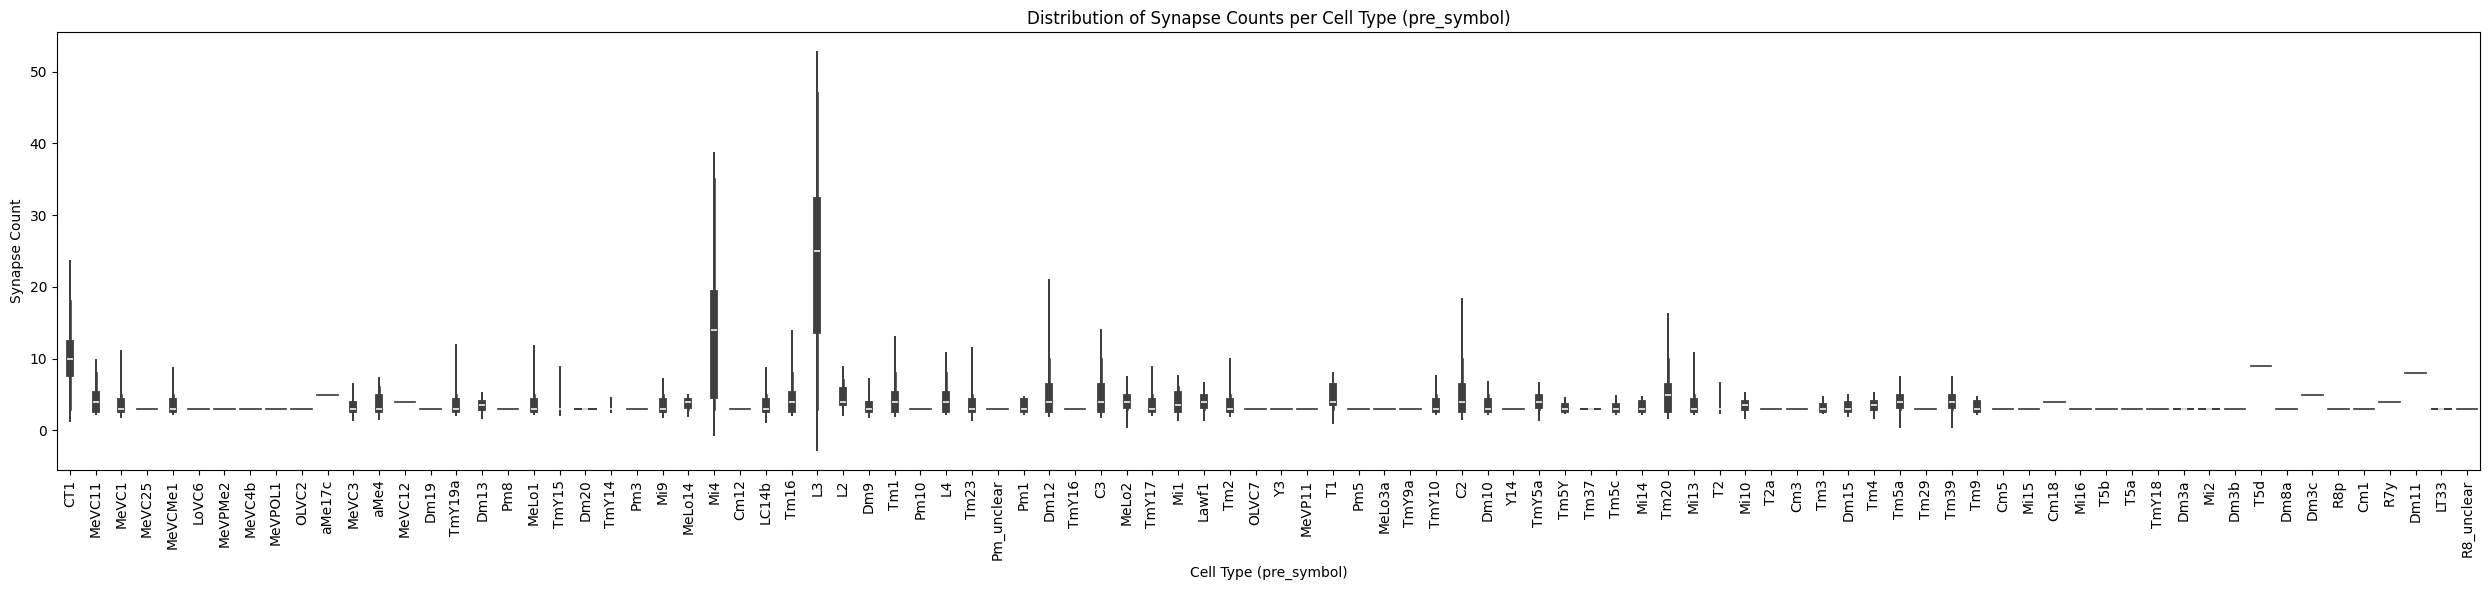

In [51]:
# Choose Tm9/Tm1
subset_df = connectivity_df[connectivity_df['post_symbol'] == 'Tm9']
subset_df = subset_df[subset_df['syn_count']>=3]
# Make sure your syn_count column is numeric
subset_df['syn_count'] = pd.to_numeric(subset_df['syn_count'])

# Create the violin plot
plt.figure(figsize=(25, 6))
sns.violinplot(data=subset_df, x='pre_symbol', y='syn_count')

# Optional: improve plot appearance
plt.xticks(rotation=90)
plt.title('Distribution of Synapse Counts per Cell Type (pre_symbol)')
plt.xlabel('Cell Type (pre_symbol)')
plt.ylabel('Synapse Count')
plt.tight_layout()
plt.show()

In [ ]:
print(subset_df.groupby('pre_symbol').size().head())

pre_symbol
C2      361
C3      548
CT1     873
Cm1       1
Cm12      3
dtype: int64


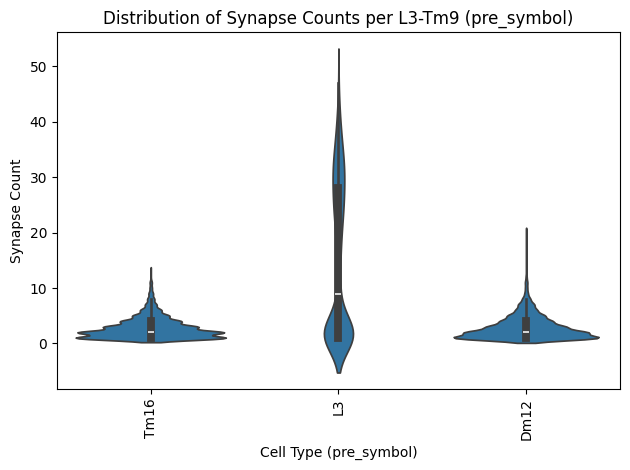

In [57]:
# Choose Tm9/Tm1
subset_df = connectivity_df[connectivity_df['post_symbol'] == 'Tm9']

cell_of_interest = ['L3','Tm16','Dm12']
subset_df = subset_df[subset_df['pre_symbol'].isin(cell_of_interest)]
# subset_df = subset_df[subset_df['syn_count']>=3]
# Make sure your syn_count column is numeric
subset_df['syn_count'] = pd.to_numeric(subset_df['syn_count'])

# Create the violin plot

sns.violinplot(data=subset_df, x='pre_symbol', y='syn_count')

# Optional: improve plot appearance
plt.xticks(rotation=90)
plt.title('Distribution of Synapse Counts per L3-Tm9 (pre_symbol)')
plt.xlabel('Cell Type (pre_symbol)')
plt.ylabel('Synapse Count')
plt.tight_layout()
plt.show()

In [63]:
subset_df = connectivity_df[connectivity_df['post_symbol'] == 'Tm9']
subset_df = connectivity_df[connectivity_df['pre_symbol'] == 'Tm16']

In [65]:
subset_df.syn_count.min()

np.int64(1)

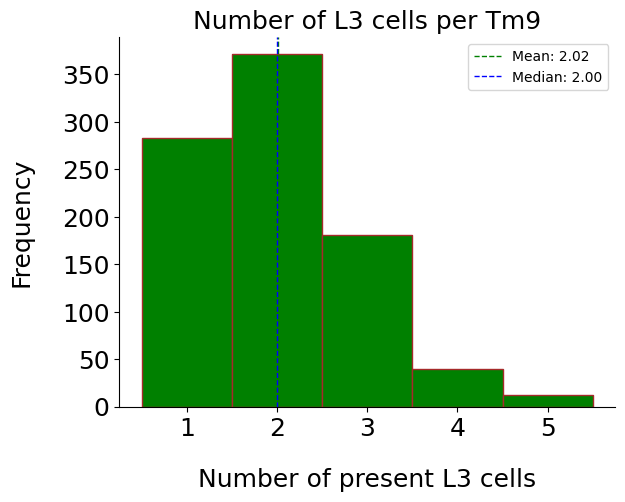

In [44]:
# Number of neurons of interest for a given T4

# plot parameteres
fig, ax = plt.subplots() 
font_size = 18
tick_size = 18

# select input
neuron_of_interest = 'L3' # ['L3', 'CT1', 'Mi4', 'Tm16', 'C3','Tm20','Dm12','Tm1','C2','L2', 'Pm08','Mi13', 'Dm15','Mi1','Mi9','Pm03']
input_df = male_df[male_df['pre_symbol'].isin([neuron_of_interest])]
# Filter for Tm9 or Tm1
post_of_interest = 'Tm9'
input_df = input_df[input_df['post_symbol'].isin([post_of_interest])]
# filter dataframe by neuro of interest

# get my frequncy for each t5 and make a histogram
frequency_df = input_df.groupby(['post_root_id']).size()
bins = [0.5 + i for i in range(max(frequency_df)+1)]  # Creates [0.5, 1.5, ..., 8.5]
ax.hist(frequency_df,bins=bins, color='green',edgecolor = 'brown') #colors[neuron_of_interest]
mean_value = frequency_df.mean()
median_value = frequency_df.median()

plt.axvline(mean_value, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {median_value:.2f}')
plt.xlabel(f'Number of present {neuron_of_interest} cells', labelpad=20, fontsize=font_size)
plt.ylabel('Frequency', labelpad=20, fontsize=font_size)
plt.title(f'Number of {neuron_of_interest} cells per {post_of_interest}',fontsize = font_size)

# Customize the axes appearance
ax.spines[['top', 'right']].set_visible(False)

plt.xticks(size=tick_size)
plt.yticks(size=tick_size)

plt.legend()

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600'),
  Text(0, 800.0, '800'),
  Text(0, 1000.0, '1000'),
  Text(0, 1200.0, '1200')])

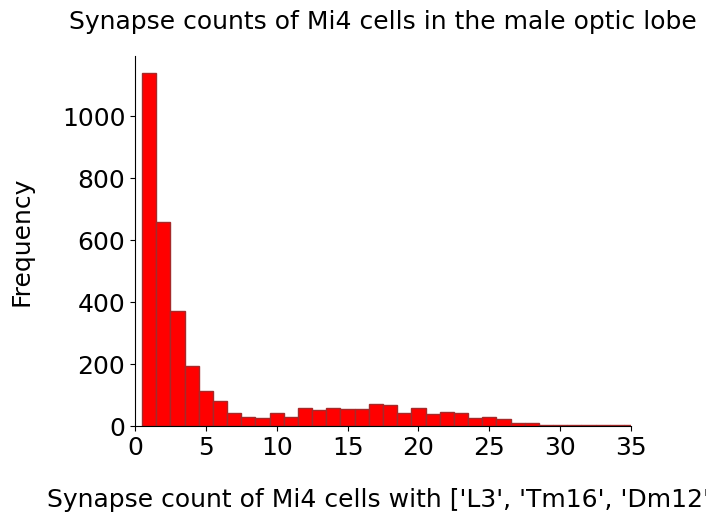

In [66]:
# Synapse distribution of neurons of interest for a given cell_of_interest

# plot parameteres
fig, ax = plt.subplots() 
font_size = 18
tick_size = 18

# select input
neuron_of_interest = 'Mi4' # 'Mi4','Mi9','Mi1','Tm3', 'CT1'
# colors = {'Mi1': 'tab:red', 'Mi4': 'tab:orange', 'Mi9': 'royalblue', 'Tm3': 'green', 'CT1': 'blue'}
# filter dataframe by neuro of interest
input_df = connectivity_df[connectivity_df['pre_symbol'].isin([neuron_of_interest])]
# get synapse count between T4 and neuron of ineterest and make a histogram

bins = [0.5 + i for i in range(max(input_df['syn_count'])+1)]  # Creates [0.5, 1.5, ..., 8.5]
ax.hist(input_df['syn_count'],bins=bins, color='red',edgecolor = 'brown') # colors[neuron_of_interest]
mean_value = input_df['syn_count'].mean()
median_value = input_df['syn_count'].median()

labelpad =20
plt.xlabel(f'Synapse count of {neuron_of_interest} cells with {cell_of_interest}', labelpad=20, fontsize=font_size)
plt.ylabel('Frequency', labelpad=20, fontsize=font_size)
plt.title(f'Synapse counts of {neuron_of_interest} cells in the male optic lobe',fontsize = font_size,pad = labelpad)
plt.xlim(0,35)
# Customize the axes appearance
ax.spines[['top', 'right']].set_visible(False)

plt.xticks(size=tick_size)
plt.yticks(size=tick_size)

## 2. Female connectome (v873)

#### i. Create database

In [ ]:
# Save working path
BASE_DIR = Path().resolve()
## Load the existing .csv.gz file with the classification of neurons
df_cell_type = pd.read_csv(BASE_DIR / r'classification.csv.gz', compression='gzip')
# optional: filter for neurons in the optic lobe otherwise skip it or choose the super_class you are interested
df_cell_type= df_cell_type[df_cell_type['super_class'] == 'optic']
# Work only with the 'right' side of the brain
df_cell_type = df_cell_type[df_cell_type['side']=='right']
# Optional: drop columns you don't care about
df_cell_type = df_cell_type.drop(columns=['super_class','side','nerve','hemilineage','hemibrain_type','sub_class','class','flow'])

### Add CT1 manually, becase the CT1 soma is located on the left side so we filtered it out when we chose 'right' side
# Create a new row to be added
new_row = pd.DataFrame({'root_id': [720575940626979621], 'cell_type': ['CT1']})
# Append the new row to the dataframe
df_cell_type = pd.concat([df_cell_type, new_row], ignore_index=True)
# Save the updated dataframe to a new CSV file
df = pd.read_csv(BASE_DIR / r'connections_no_threshold.csv.gz', compression='gzip')

In [36]:
df_cell_type

,root_id,cell_type
0,720575940640144768,L1
1,720575940618363515,Tm1
2,720575940627317002,L3
3,720575940614361263,Tm20
4,720575940638574936,Mi9
...,...,...
38472,720575940629343591,Tm3
38473,720575940626358349,Tm16
38474,720575940618375569,L2
38475,720575940624423312,TmY5a


In [35]:
df

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940623828999,720575940612348950,SLP_R,4,GLUT
2,720575940624078484,720575940616950161,SMP_R,2,ACH
3,720575940629583345,720575940620324735,SMP_L,2,GLUT
4,720575940605876866,720575940606514878,LAL_R,15,GABA
...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,ACH
16847993,720575940624016823,720575940622760993,ME_R,4,ACH
16847994,720575940637397309,720575940633255123,SLP_R,2,GABA
16847995,720575940636432014,720575940617470681,ME_R,1,GLUT


In [37]:
### Map the cell type to the root_id
# Create a dictionary to map root_id to cell_type
postsynaptic_map = dict(zip(df_cell_type['root_id'], df_cell_type['cell_type']))
# create two new columns of the cell type pre and post and use the dictionary to map the cell type based on the root_id
df['post_symbol'] = df['post_root_id'].map(postsynaptic_map)
df['pre_symbol'] = df['pre_root_id'].map(postsynaptic_map)
# Drop rows without identified pre or post cell type
df = df.dropna()

In [38]:
df

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,post_symbol,pre_symbol
15,720575940620963920,720575940619093761,LA_R,4,ACH,Am,Lawf2
593,720575940660573313,720575940617301691,LA_R,15,ACH,Am,Lawf2
642,720575940612531921,720575940622728157,LA_R,11,ACH,L2,C2
877,720575940620941446,720575940632481295,LA_R,2,DA,T1,Lawf1
1099,720575940612878554,720575940613409945,LA_R,1,ACH,Lawf1,Lawf2
...,...,...,...,...,...,...,...
16847983,720575940625822612,720575940625700685,ME_R,1,ACH,Dm3,CB3816
16847985,720575940630831738,720575940616722393,ME_R,1,GLUT,T2,Tm4
16847988,720575940615147020,720575940639385149,ME_R,1,GABA,T2a,TmY15
16847993,720575940624016823,720575940622760993,ME_R,4,ACH,TmY4,CB3816


In [39]:
### Add column assignment
column_assignemnt = pd.read_csv(BASE_DIR / r"column_assignment.csv.gz", compression='gzip')
postsynaptic_map = dict(zip(column_assignemnt['root_id'], column_assignemnt['column_id']))
# Use the dictionary with map to assign post_symbol to CT1_db
df['post_column_id'] = df['post_root_id'].map(postsynaptic_map)
df['pre_column_id'] = df['pre_root_id'].map(postsynaptic_map)

C:\Users\maria\AppData\Local\Temp\ipykernel_28208\744816846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_column_id'] = df['post_root_id'].map(postsynaptic_map)
C:\Users\maria\AppData\Local\Temp\ipykernel_28208\744816846.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_column_id'] = df['pre_root_id'].map(postsynaptic_map)


In [40]:
df = df[df['post_symbol'].isin(['Tm1','Tm9'])]

In [42]:
df.post_symbol.unique()

array(['Tm1', 'Tm9'], dtype=object)

In [ ]:
### Filter for the neurons of interest
df = df[df['post_symbol'].isin(['Tm1','Tm9'])]
### Save the dataframe with the connections and cell type identification and column assignment, choose the name
df.to_csv(BASE_DIR / r"connections_no_threshold_v783_ROL_Tm1_Tm9_upstream.csv", index = False)

#### ii. Data Analysis

In [ ]:
# Load database into a dataframe
female_df = pd.read_csv(BASE_DIR / r"connections_no_threshold_v783_ROL_Tm1_Tm9_upstream.csv")

In [45]:
female_df

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,post_symbol,pre_symbol,post_column_id,pre_column_id
0,720575940625438138,720575940616746845,UNASGD,1,ACH,Tm1,T1,609.0,609.0
1,720575940622217430,720575940616414523,ME_R,2,GLUT,Tm1,Mi14,29.0,NaN
2,720575940632351506,720575940638169688,ME_R,4,GABA,Tm1,Pm2,706.0,NaN
3,720575940606775486,720575940621966294,ME_R,1,GABA,Tm1,Dm19,211.0,NaN
4,720575940629757050,720575940615607106,ME_R,1,GLUT,Tm1,Tm4,467.0,467.0
...,...,...,...,...,...,...,...,...,...
66669,720575940620536589,720575940632565075,ME_R,4,ACH,Tm9,Tm16,114.0,NaN
66670,720575940631516690,720575940612975786,ME_R,1,GLUT,Tm1,Dm3,603.0,NaN
66671,720575940618651170,720575940616575500,ME_R,1,ACH,Tm9,L4,266.0,104.0
66672,720575940623337596,720575940614164655,ME_R,3,GABA,Tm1,Pm2,30.0,NaN


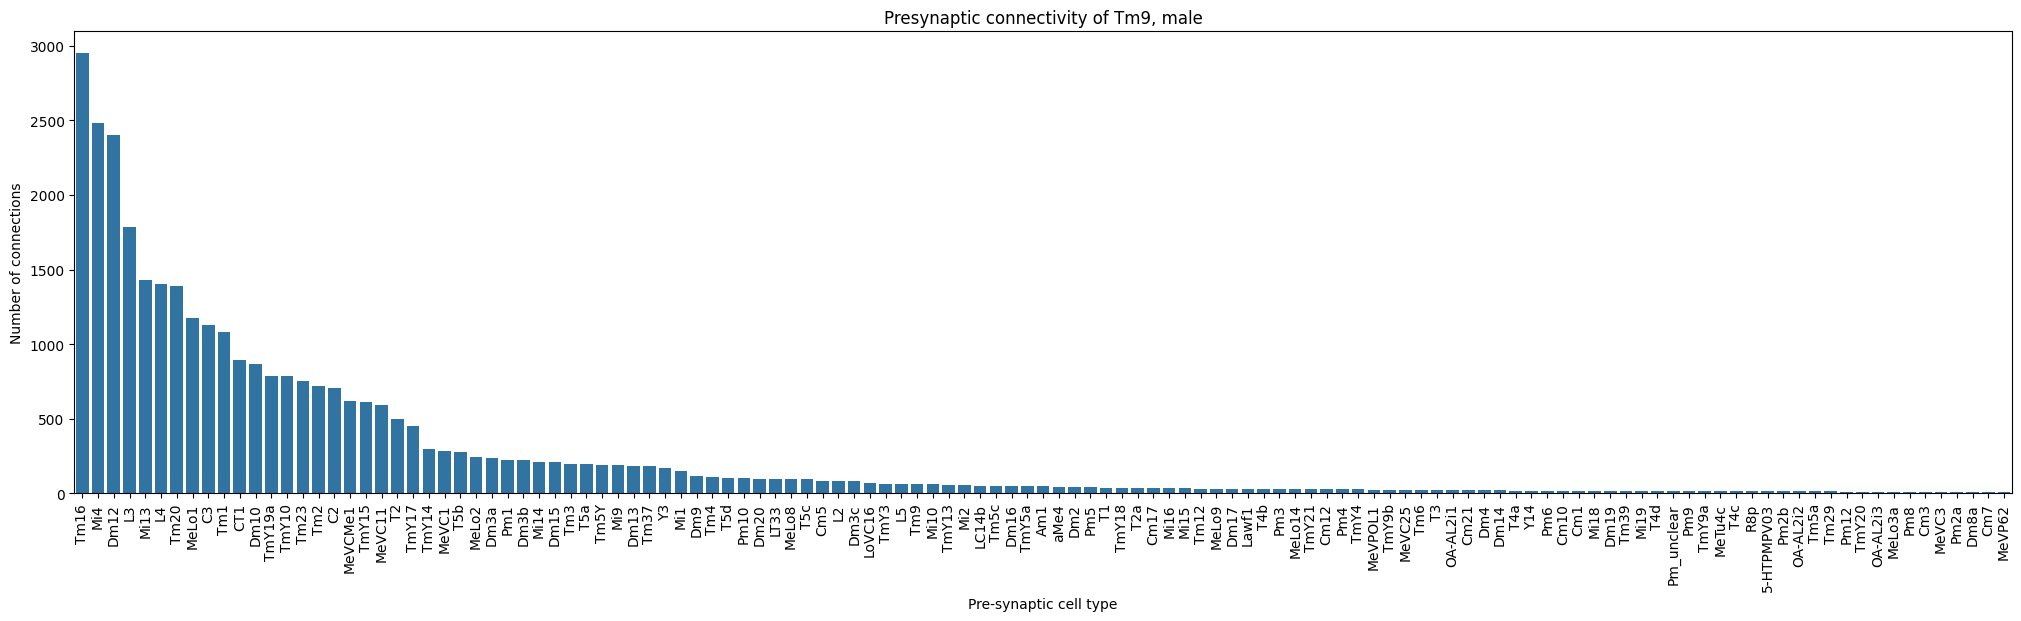

In [67]:
import seaborn as sns
# You can choose FEMALE/MALE
# You can choose Tm1/Tm9 
input_df = pd.read_csv(BASE_DIR / r'male_database.csv') #"connections_no_threshold_v783_ROL_Tm1_Tm9_upstream.csv"
neuron_of_interest = 'Tm9'
connectome = 'male'

subset_df = input_df[input_df['post_symbol'] == neuron_of_interest]
connections_number = subset_df.groupby(['pre_symbol']).size().reset_index(name='count')

connections_number = connections_number.sort_values(by='count', ascending=False)
connections_number = connections_number[connections_number['count']>=10]
plt.figure(figsize=(25, 6))
sns.barplot(data = connections_number, x='pre_symbol', y='count')
plt.xticks(rotation=90)
plt.ylabel('Number of connections')
plt.xlabel('Pre-synaptic cell type')
plt.title(f'Presynaptic connectivity of {neuron_of_interest}, {connectome}')
plt.show()

In [56]:
connections_number = connections_number.sort_values(by='count', ascending=False)

In [58]:
connections_number

,pre_symbol,count
76,Pm2,6620
74,Pm1,5917
42,Dm15,2888
67,Mi13,2580
45,Dm19,2576
...,...,...
11,CB3825,1
12,CB3826,1
64,MeMe_e11,1
59,LPi12,1


In [48]:
subset_df.post_symbol.unique()

array(['Tm1'], dtype=object)

(<Figure size 720x720 with 1 Axes>, <Axes3D: xlabel='x', ylabel='y'>)

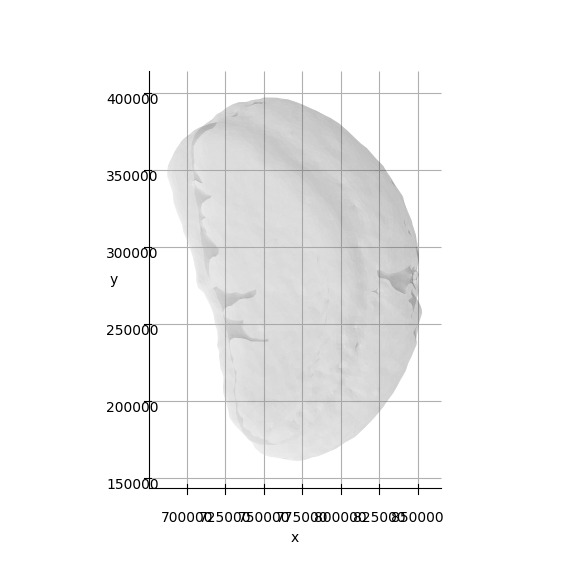

In [ ]:
### Neuron and neuropile visualization
mesh_OL_R = 'ME_R' # This is correct for fafbseq version 1.14.0 and before 
OL_R = flywire.get_neuropil_volumes([mesh_OL_R]) #['ME_R','LO_R','LOP_R']

navis.plot2d([OL_R], method='3d_complex')

## Female - Male comparison

In [43]:
### How many Tm1/Tm9 in male and female

# load male
male_df = pd.read_csv(BASE_DIR / r'male_database.csv')

# load female
female_df = pd.read_csv(BASE_DIR / r'connections_no_threshold_v783_ROL_Tm1_Tm9_upstream.csv')

# Get the number of unique post_root_id for Tm1 and Tm9
dataset = 'male'
neuron_of_interest = 'Tm9'
male_df_subset = male_df[male_df['post_symbol'] == neuron_of_interest]

unique_number = male_df_subset['post_root_id'].nunique()
print(f'The number of unique {neuron_of_interest}s in the {dataset} optic lobe is {unique_number}')

# Get the number of unique post_root_id for Tm1 and Tm9
dataset = 'female'
neuron_of_interest = 'Tm9'
male_df_subset = female_df[female_df['post_symbol'] == neuron_of_interest]

unique_number = male_df_subset['post_root_id'].nunique()
print(f'The number of unique {neuron_of_interest}s in the {dataset} optic lobe is {unique_number}')

The number of unique Tm9s in the male optic lobe is 887
The number of unique Tm9s in the female optic lobe is 750


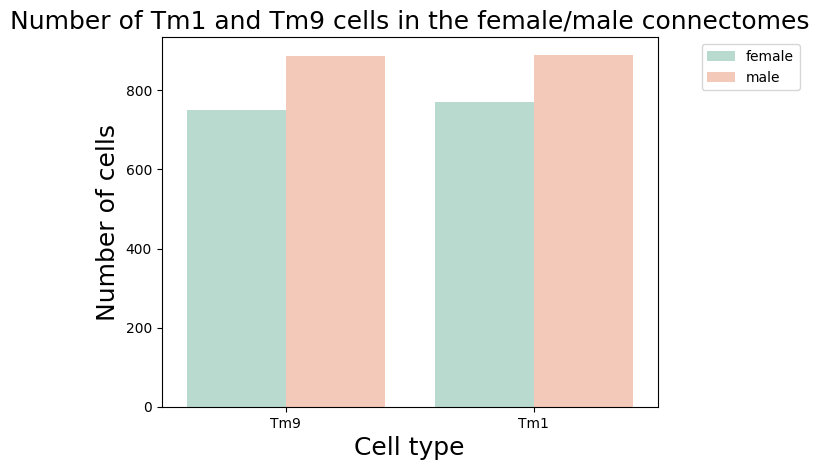

In [81]:
### How many Tm1/Tm9 in male and female
neuron_of_interest = 'Tm9' # here can put Tm1 instead
male_df_subset = male_df[male_df['post_symbol'] == neuron_of_interest]
female_df_subset = female_df[female_df['post_symbol'] == neuron_of_interest]
unique_number_f_tm9 = female_df_subset['post_root_id'].nunique()
unique_number_m_tm9 = male_df_subset['post_root_id'].nunique()
neuron_of_interest = 'Tm1' # here can put Tm1 instead
male_df_subset = male_df[male_df['post_symbol'] == neuron_of_interest]
female_df_subset = female_df[female_df['post_symbol'] == neuron_of_interest]
unique_number_f_tm1 = female_df_subset['post_root_id'].nunique()
unique_number_m_tm1 = male_df_subset['post_root_id'].nunique()
d = {'number_of_cells': [unique_number_f_tm9,unique_number_m_tm9,unique_number_f_tm1,unique_number_m_tm1],'connectome': ['female','male','female','male'],'cell_type':['Tm9','Tm9','Tm1','Tm1']} #, 'celltype':['Tm1','Tm9']
unique_values_df = pd.DataFrame(data=d)  
sns.barplot(data=unique_values_df, x='cell_type', y='number_of_cells', hue='connectome',  palette='Set2', alpha =0.5)
plt.ylabel('Number of cells', fontsize=18)
plt.title('Number of Tm1 and Tm9 cells in the female/male connectomes', fontsize=18)
plt.xlabel('Cell type', fontsize=18)
plt.legend(loc='best', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))

Text(0, 0.5, 'Number of connections')

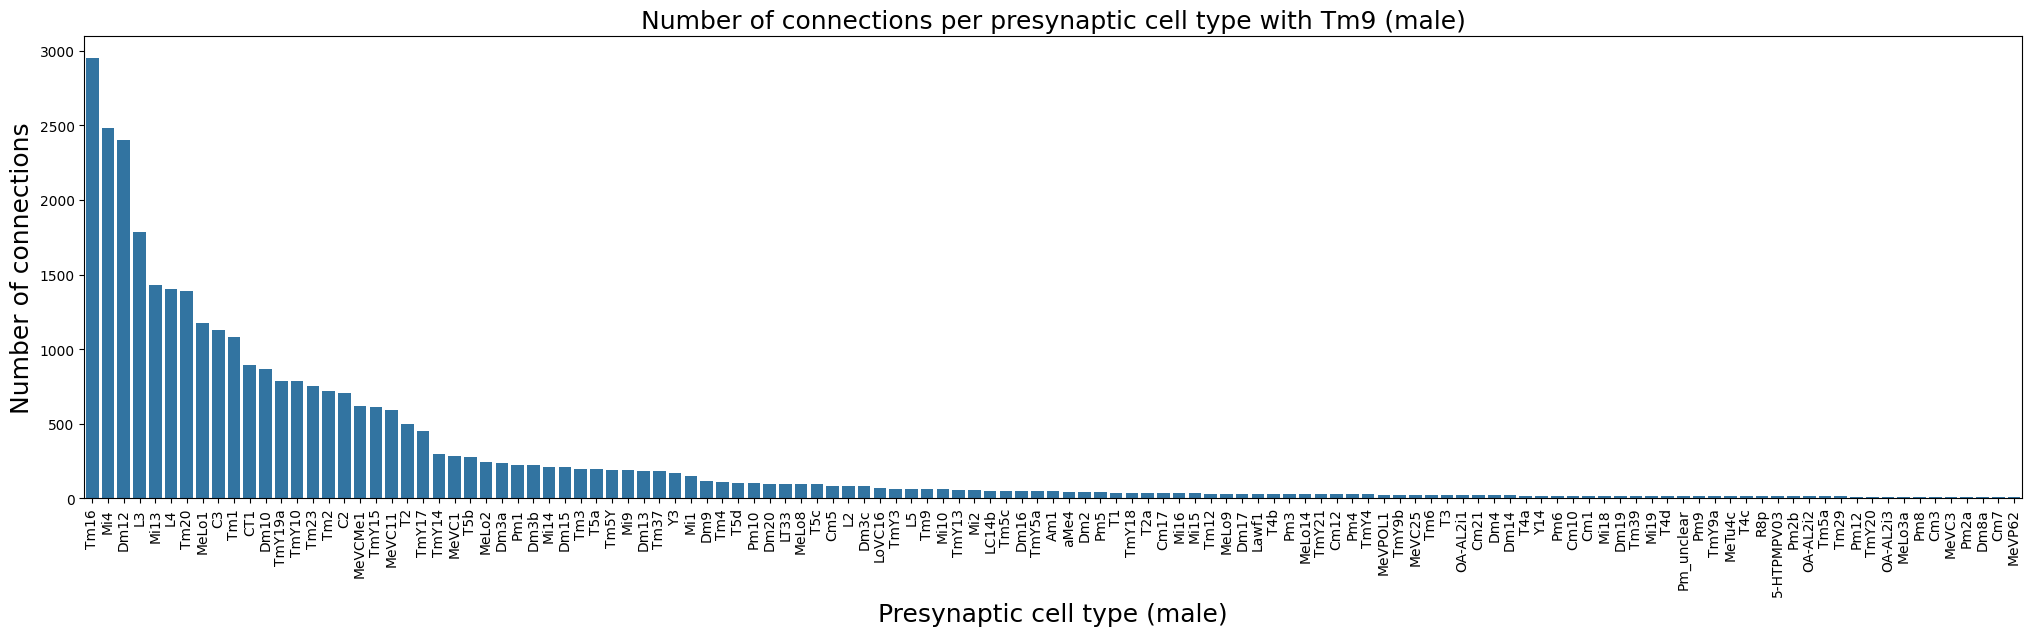

In [117]:
# Male : number of connections per cell type
male_df = pd.read_csv(BASE_DIR / r'male_database.csv')
# Tm9
subset_df = male_df[male_df['post_symbol'] == 'Tm9']
connections_number = subset_df.groupby(['pre_symbol']).size().reset_index(name='count')
connections_number = connections_number.sort_values(by='count', ascending=False)
connections_number = connections_number[connections_number['count'] >= 10]
plt.figure(figsize=(25, 6))
sns.barplot(data=connections_number, x='pre_symbol', y = 'count')
plt.xticks(rotation=90)
plt.title('Number of connections per presynaptic cell type with Tm9 (male)', fontsize=18)
plt.xlabel('Presynaptic cell type (male)', fontsize=18)
plt.ylabel('Number of connections', fontsize=18)

Text(0, 0.5, 'Number of connections')

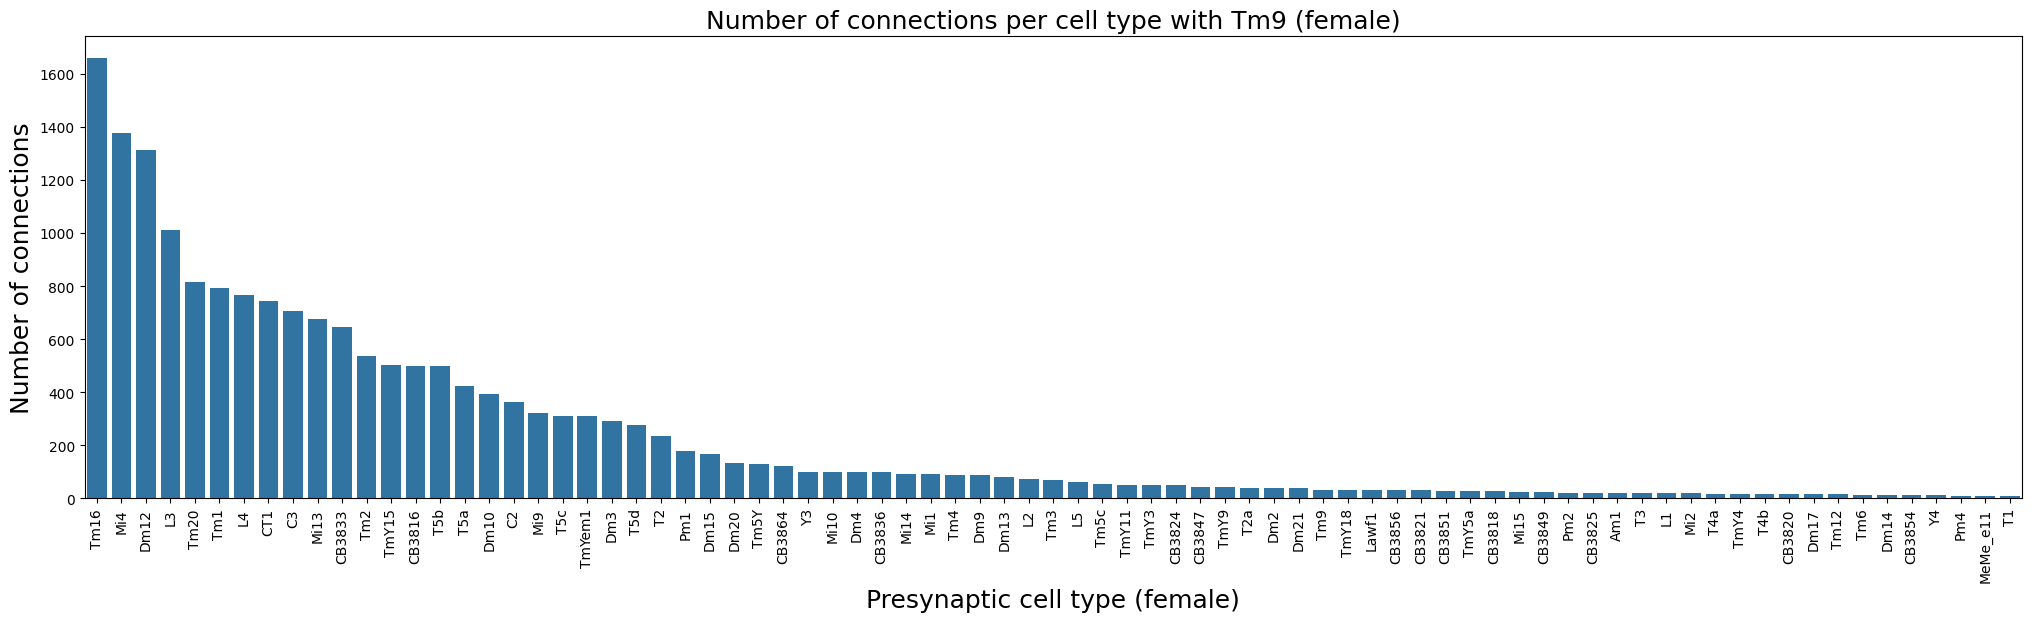

In [116]:
# Female : number of connections per cell type
female_df = pd.read_csv(BASE_DIR / r'connections_no_threshold_v783_ROL_Tm1_Tm9_upstream.csv')
# Tm9
subset_df = female_df[female_df['post_symbol'] == 'Tm9']
connections_number = subset_df.groupby(['pre_symbol']).size().reset_index(name='count')
connections_number = connections_number.sort_values(by='count', ascending=False)
connections_number = connections_number[connections_number['count'] >= 10]
plt.figure(figsize=(25, 6))
sns.barplot(data=connections_number, x='pre_symbol', y = 'count')
plt.xticks(rotation=90)
plt.title('Number of connections per cell type with Tm9 (female)', fontsize=18)
plt.xlabel('Presynaptic cell type (female)', fontsize=18)
plt.ylabel('Number of connections', fontsize=18)

Text(0, 0.5, 'Number of connections')

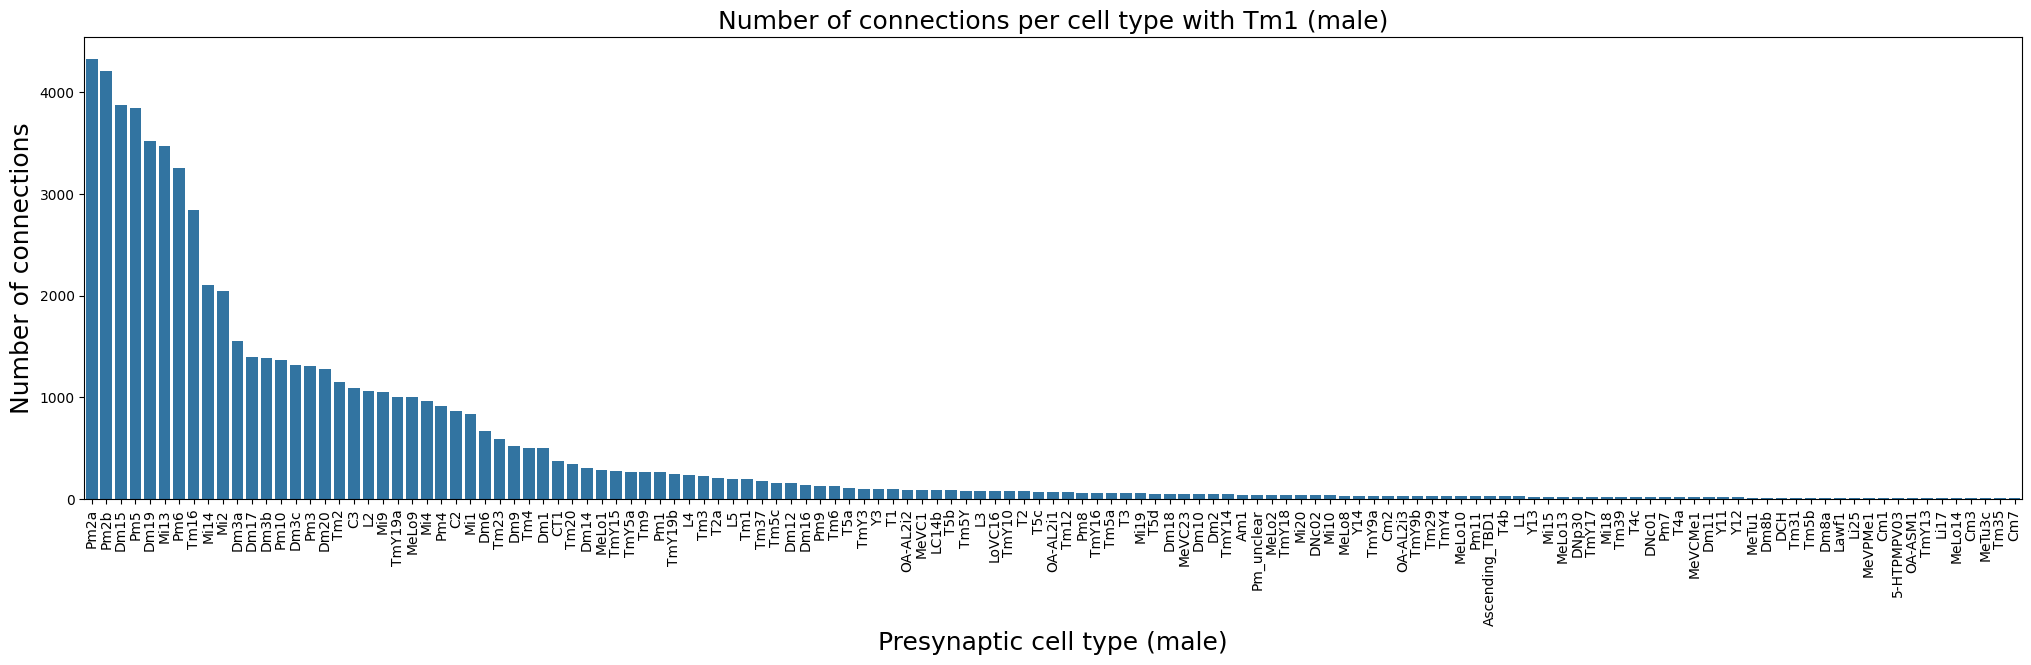

In [114]:
# Male : number of connections per cell type
male_df = pd.read_csv(BASE_DIR / r'male_database.csv')
# Tm1
subset_df = male_df[male_df['post_symbol'] == 'Tm1']
connections_number = subset_df.groupby(['pre_symbol']).size().reset_index(name='count')
connections_number = connections_number.sort_values(by='count', ascending=False)
connections_number = connections_number[connections_number['count'] >= 10]
plt.figure(figsize=(25, 6))
sns.barplot(data=connections_number, x='pre_symbol', y = 'count')
plt.xticks(rotation=90)
plt.title('Number of connections per cell type with Tm1 (male)', fontsize=18)
plt.xlabel('Presynaptic cell type (male)', fontsize=18)
plt.ylabel('Number of connections', fontsize=18)

Text(0, 0.5, 'Number of connections')

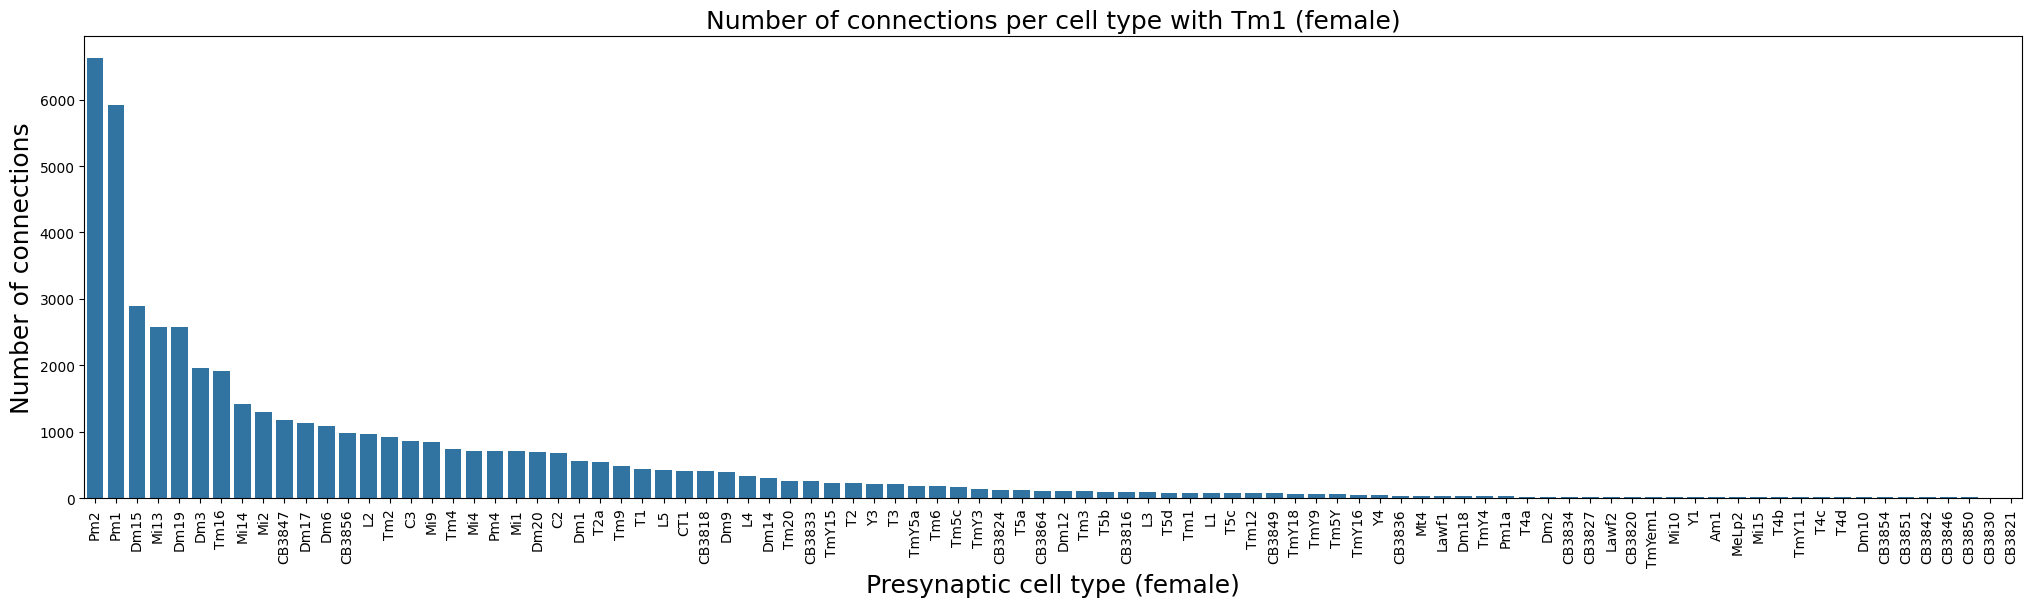

In [113]:
# Female : number of connections per cell type
female_df = pd.read_csv(BASE_DIR / r'connections_no_threshold_v783_ROL_Tm1_Tm9_upstream.csv')
# Tm1
subset_df = female_df[female_df['post_symbol'] == 'Tm1']
connections_number = subset_df.groupby(['pre_symbol']).size().reset_index(name='count')
connections_number = connections_number.sort_values(by='count', ascending=False)
connections_number = connections_number[connections_number['count'] >= 10]
plt.figure(figsize=(25, 6))
sns.barplot(data=connections_number, x='pre_symbol', y = 'count')
plt.xticks(rotation=90)
plt.title('Number of connections per cell type with Tm1 (female)', fontsize=18)
plt.xlabel('Presynaptic cell type (female)', fontsize=18)
plt.ylabel('Number of connections', fontsize=18)

Text(0, 0.5, 'Number of connections')

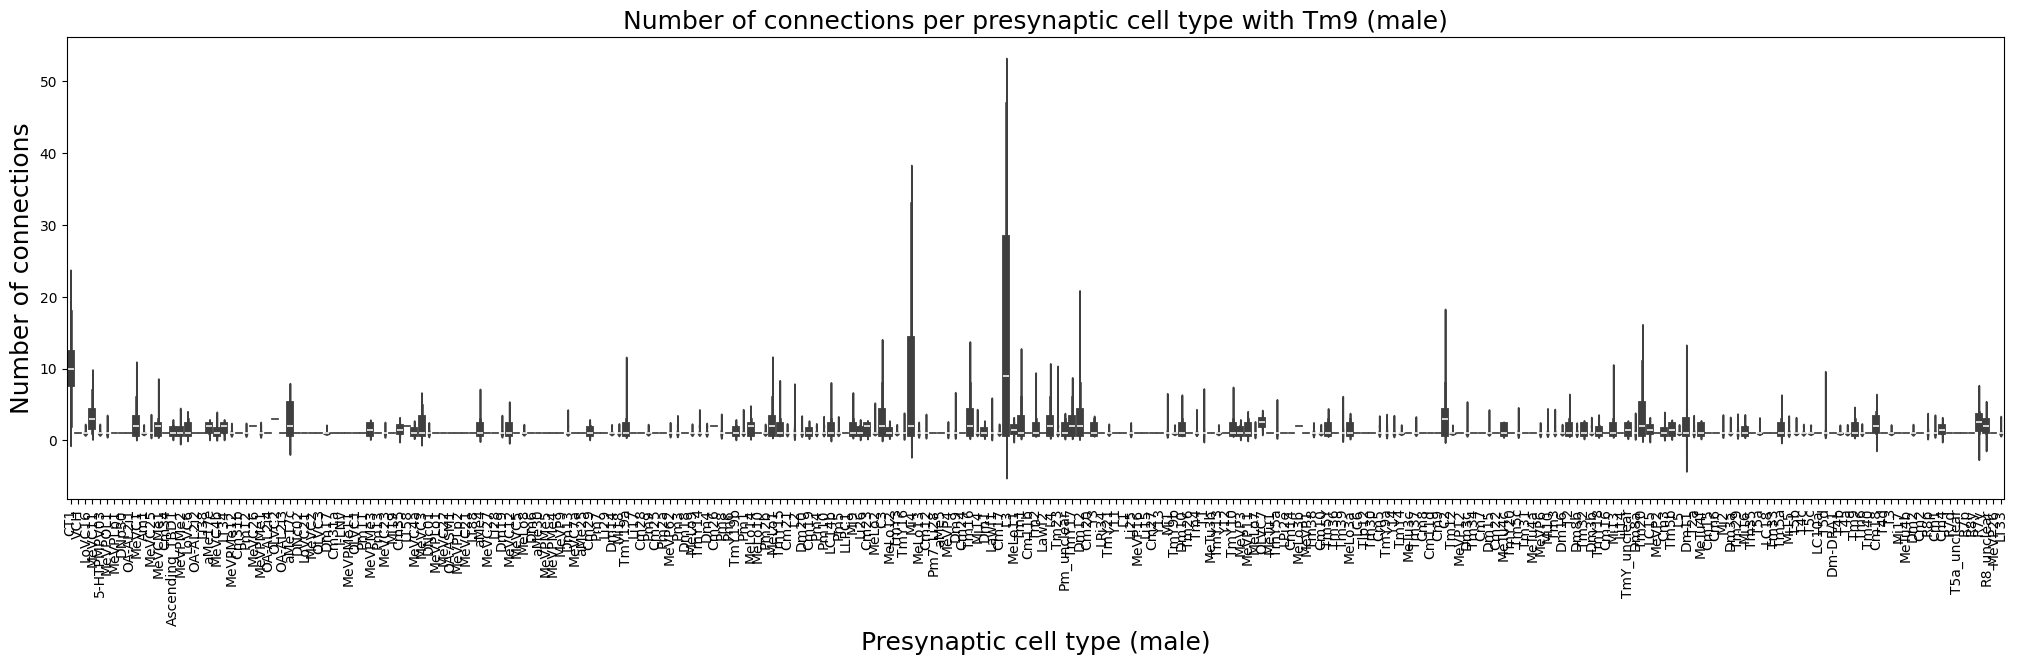

In [127]:
### # Male : number of synapses per cell type
male_df = pd.read_csv(BASE_DIR / r'male_database.csv')
# Tm9
subset_df = male_df[male_df['post_symbol'] == 'Tm9']

plt.figure(figsize=(25, 6))

sns.violinplot(data=subset_df, x='pre_symbol', y='syn_count', inner='box')
plt.xticks(rotation=90)
plt.title('Number of connections per presynaptic cell type with Tm9 (male)', fontsize=18)
plt.xlabel('Presynaptic cell type (male)', fontsize=18)
plt.ylabel('Number of connections', fontsize=18)

Text(0, 0.5, 'Number of connections')

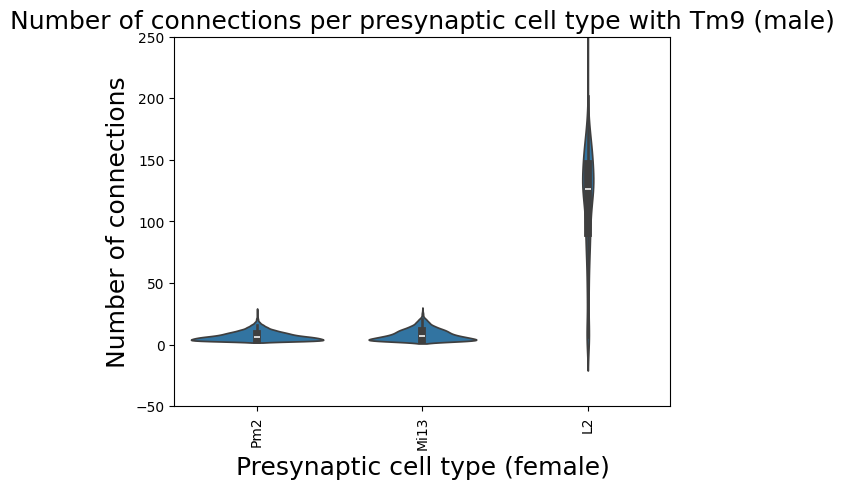

In [139]:
### # MFEmale : number of synapses per cell type
male_df = pd.read_csv(BASE_DIR / r'connections_no_threshold_v783_ROL_Tm1_Tm9_upstream.csv')
# Tm9
subset_df = male_df[male_df['post_symbol'] == 'Tm1']
neuron_of_interest = ['L2','Pm2','Mi13']
subset_df = subset_df[subset_df['pre_symbol'].isin(neuron_of_interest)]
subset_df = subset_df[subset_df['syn_count']>=3]
# plt.figure(figsize=(25, 6))

sns.violinplot(data=subset_df, x='pre_symbol', y='syn_count', inner='box')
plt.xticks(rotation=90)
plt.ylim(-50, 250)
plt.title('Number of connections per presynaptic cell type with Tm9 (male)', fontsize=18)
plt.xlabel('Presynaptic cell type (female)', fontsize=18)
plt.ylabel('Number of connections', fontsize=18)

Text(0, 0.5, 'Number of connections')

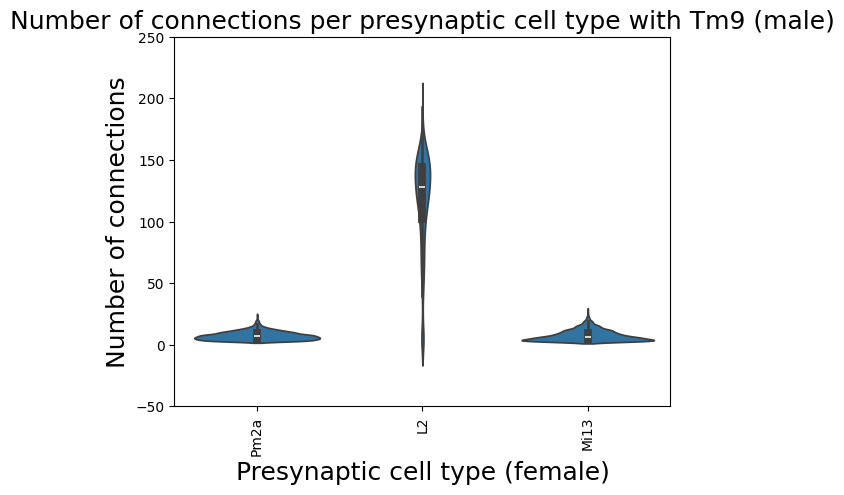

In [143]:
### # MFEmale : number of synapses per cell type
male_df = pd.read_csv(BASE_DIR / r'male_database.csv')
# Tm9
subset_df = male_df[male_df['post_symbol'] == 'Tm1']
neuron_of_interest = ['L2','Pm2a','Mi13']
subset_df = subset_df[subset_df['pre_symbol'].isin(neuron_of_interest)]
subset_df = subset_df[subset_df['syn_count']>=3]
# plt.figure(figsize=(25, 6))

sns.violinplot(data=subset_df, x='pre_symbol', y='syn_count', inner='box')
plt.xticks(rotation=90)
plt.ylim(-50, 250)
plt.title('Number of connections per presynaptic cell type with Tm9 (male)', fontsize=18)
plt.xlabel('Presynaptic cell type (female)', fontsize=18)
plt.ylabel('Number of connections', fontsize=18)

In [ ]:
male_df

,pre_root_id,post_root_id,syn_count,pre_symbol,post_symbol
0,10009,24579,1,CT1,Tm1
1,10009,30145,1,CT1,Tm1
2,10009,38782,1,CT1,Tm1
3,10009,39697,10,CT1,Tm9
4,10009,39810,1,CT1,Tm1
...,...,...,...,...,...
96905,282518677,96169,4,Dm10,Tm9
96906,282518677,106017,1,Dm10,Tm9
96907,282518677,117661,1,Dm10,Tm9
96908,282518677,131466,1,Dm10,Tm9


Text(0, 0.5, 'Number of connections')

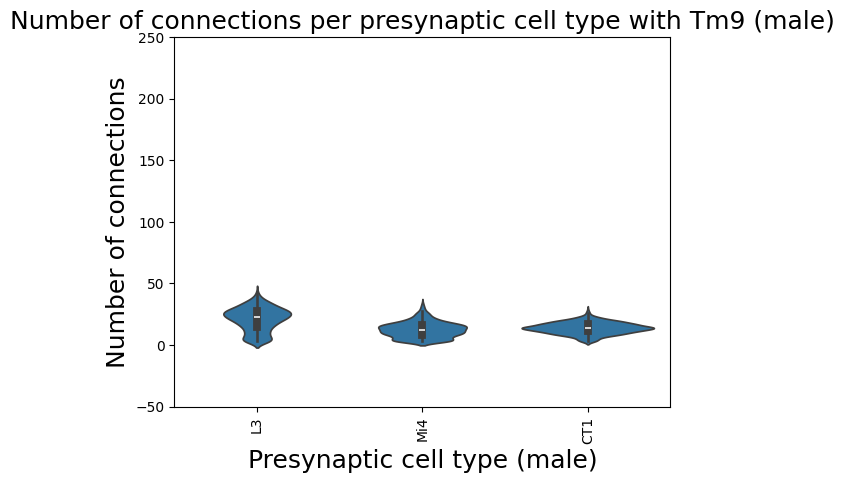

In [137]:
### # MFEmale : number of synapses per cell type
male_df = pd.read_csv(BASE_DIR / r'connections_no_threshold_v783_ROL_Tm1_Tm9_upstream.csv')
# Tm9
subset_df = male_df[male_df['post_symbol'] == 'Tm9']
neuron_of_interest = ['L3','CT1','Mi4']
subset_df = subset_df[subset_df['pre_symbol'].isin(neuron_of_interest)]
subset_df = subset_df[subset_df['syn_count']>=3]
# plt.figure(figsize=(25, 6))

sns.violinplot(data=subset_df, x='pre_symbol', y='syn_count', inner='box')
plt.xticks(rotation=90)
plt.ylim(-50, 250)
plt.title('Number of connections per presynaptic cell type with Tm9 (male)', fontsize=18)
plt.xlabel('Presynaptic cell type (male)', fontsize=18)
plt.ylabel('Number of connections', fontsize=18)

Text(0, 0.5, 'Number of connections')

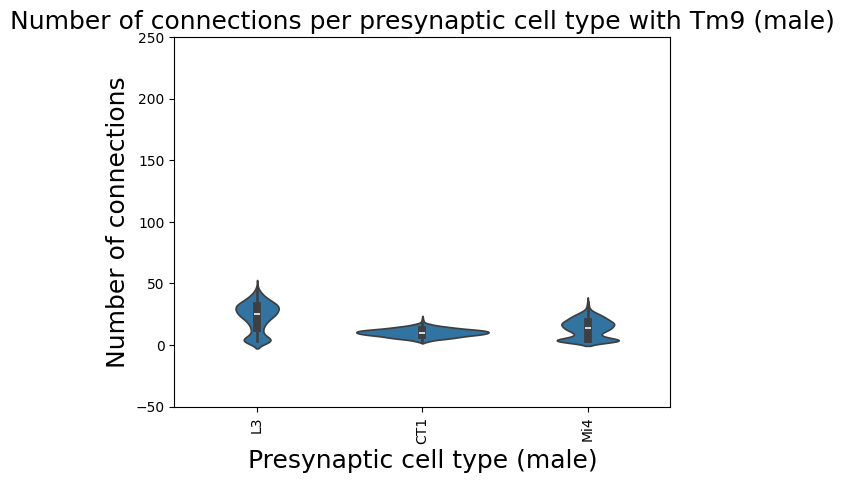

In [146]:
### # Male : number of synapses per cell type
male_df = pd.read_csv(BASE_DIR / r'male_database.csv')
# Tm9
subset_df = male_df[male_df['post_symbol'] == 'Tm9']
neuron_of_interest = ['L3','CT1','Mi4']
subset_df = subset_df[subset_df['pre_symbol'].isin(neuron_of_interest)]
subset_df = subset_df[subset_df['syn_count']>=3]
# plt.figure(figsize=(25, 6))

sns.violinplot(data=subset_df, x='pre_symbol', y='syn_count', inner='box', order=['L3','CT1','Mi4'])
plt.xticks(rotation=90)
plt.ylim(-50, 250)
plt.title('Number of connections per presynaptic cell type with Tm9 (male)', fontsize=18)
plt.xlabel('Presynaptic cell type (male)', fontsize=18)
plt.ylabel('Number of connections', fontsize=18)

In [126]:
connections_number.pre_symbol.nunique()

116

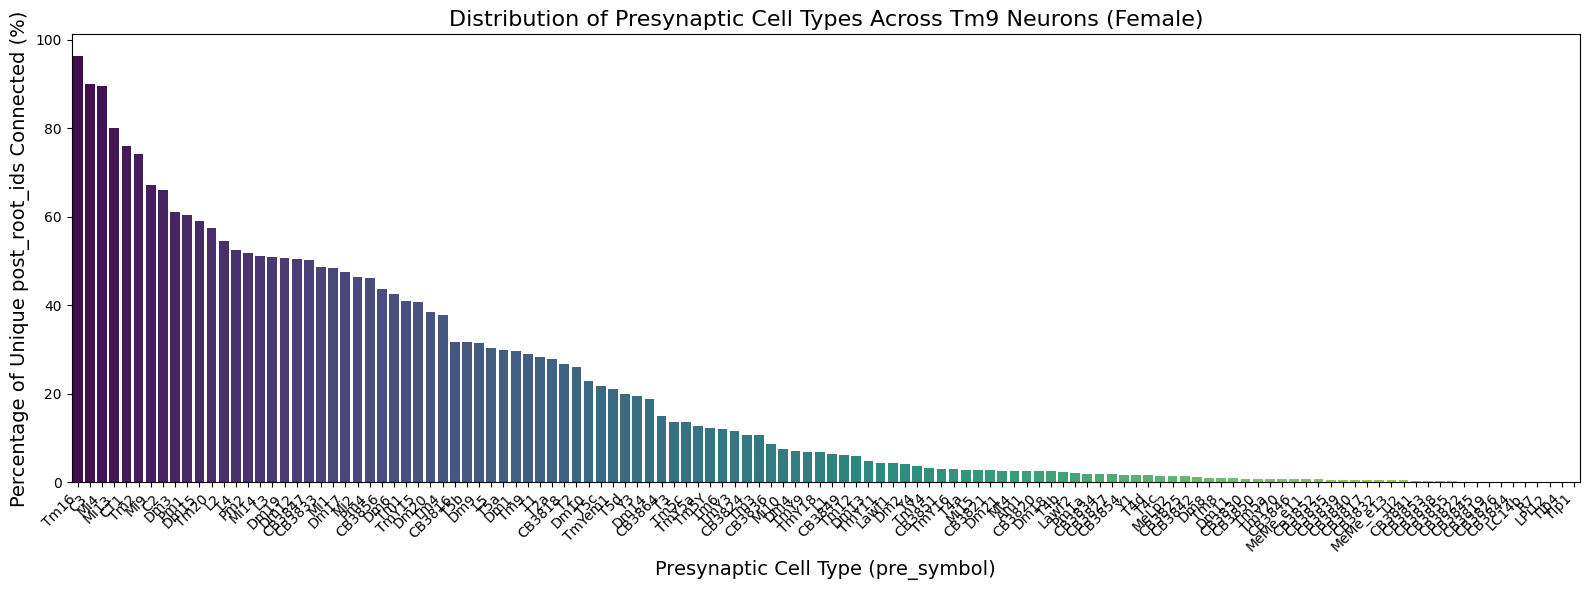

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Count unique post_root_id connections per pre_symbol
connections_per_pre = (
    female_df.groupby('pre_symbol')['post_root_id']
    .nunique()
    .reset_index(name='unique_post_targets')
)

# Step 2: Total number of unique post_root_ids
total_unique_post = female_df['post_root_id'].nunique()

# Step 3: Compute percentage
connections_per_pre['percentage'] = (connections_per_pre['unique_post_targets'] / total_unique_post) * 100

# Step 4: Sort by percentage
connections_per_pre = connections_per_pre.sort_values(by='percentage', ascending=False)

# Step 5: Plot
plt.figure(figsize=(16, 6))
sns.barplot(data=connections_per_pre, x='pre_symbol', y='percentage', palette='viridis')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Unique post_root_ids Connected (%)', fontsize=14)
plt.xlabel('Presynaptic Cell Type (pre_symbol)', fontsize=14)
plt.title('Distribution of Presynaptic Cell Types Across Tm9 Neurons (Female)', fontsize=16)
plt.tight_layout()
plt.show()


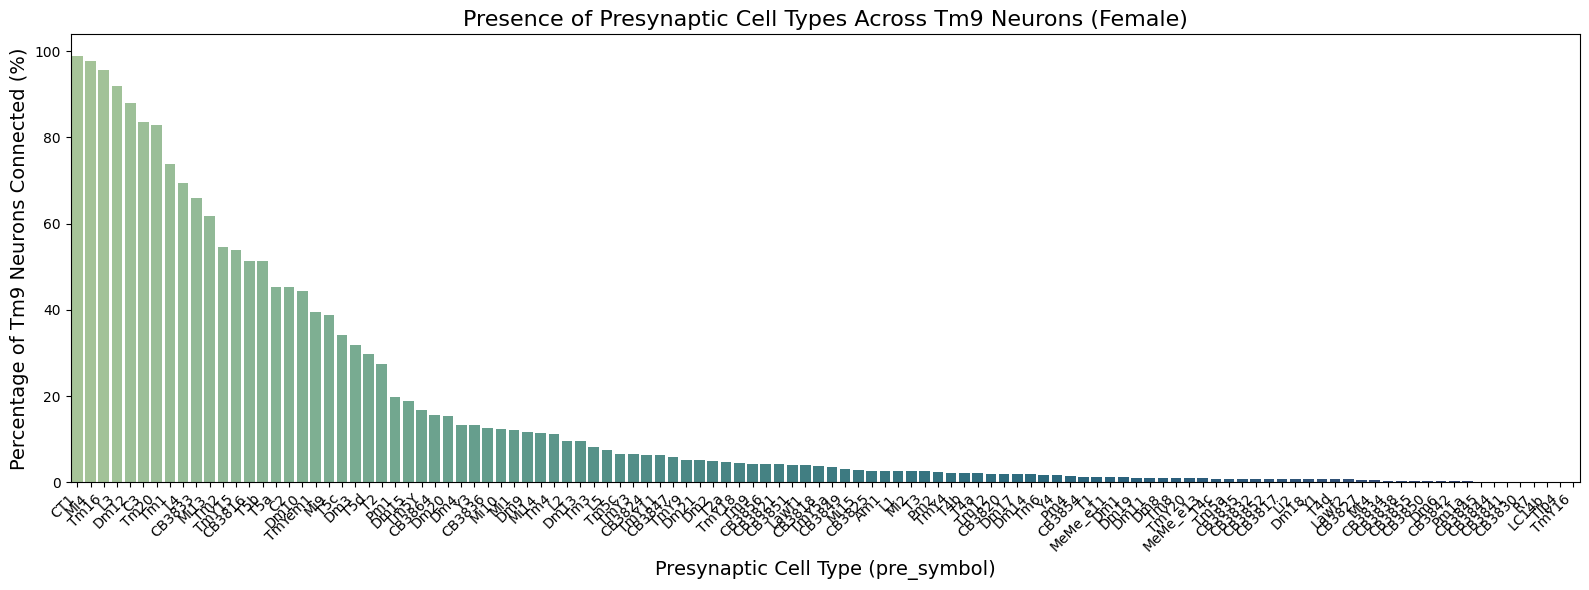

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
male_df = pd.read_csv(BASE_DIR / r'connections_no_threshold_v783_ROL_Tm1_Tm9_upstream.csv')
# Tm9
subset_df = male_df[male_df['post_symbol'] == 'Tm9']
# Step 1: Get total unique post_root_ids
total_post_ids = subset_df['post_root_id'].nunique()

# Step 2: For each (post_root_id, pre_symbol), mark presence
presence_df = subset_df[['post_root_id', 'pre_symbol']].drop_duplicates()

# Step 3: For each pre_symbol, count how many unique post_root_ids it appears in
presence_counts = presence_df.groupby('pre_symbol')['post_root_id'].nunique().reset_index(name='post_count')

# Step 4: Convert to percentage
presence_counts['percentage'] = (presence_counts['post_count'] / total_post_ids) * 100

# Step 5: Sort and plot
presence_counts = presence_counts.sort_values(by='percentage', ascending=False)

plt.figure(figsize=(16, 6))
sns.barplot(data=presence_counts, x='pre_symbol', y='percentage', palette='crest')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Tm9 Neurons Connected (%)', fontsize=14)
plt.xlabel('Presynaptic Cell Type (pre_symbol)', fontsize=14)
plt.title('Presence of Presynaptic Cell Types Across Tm9 Neurons (Female)', fontsize=16)
plt.tight_layout()
plt.show()


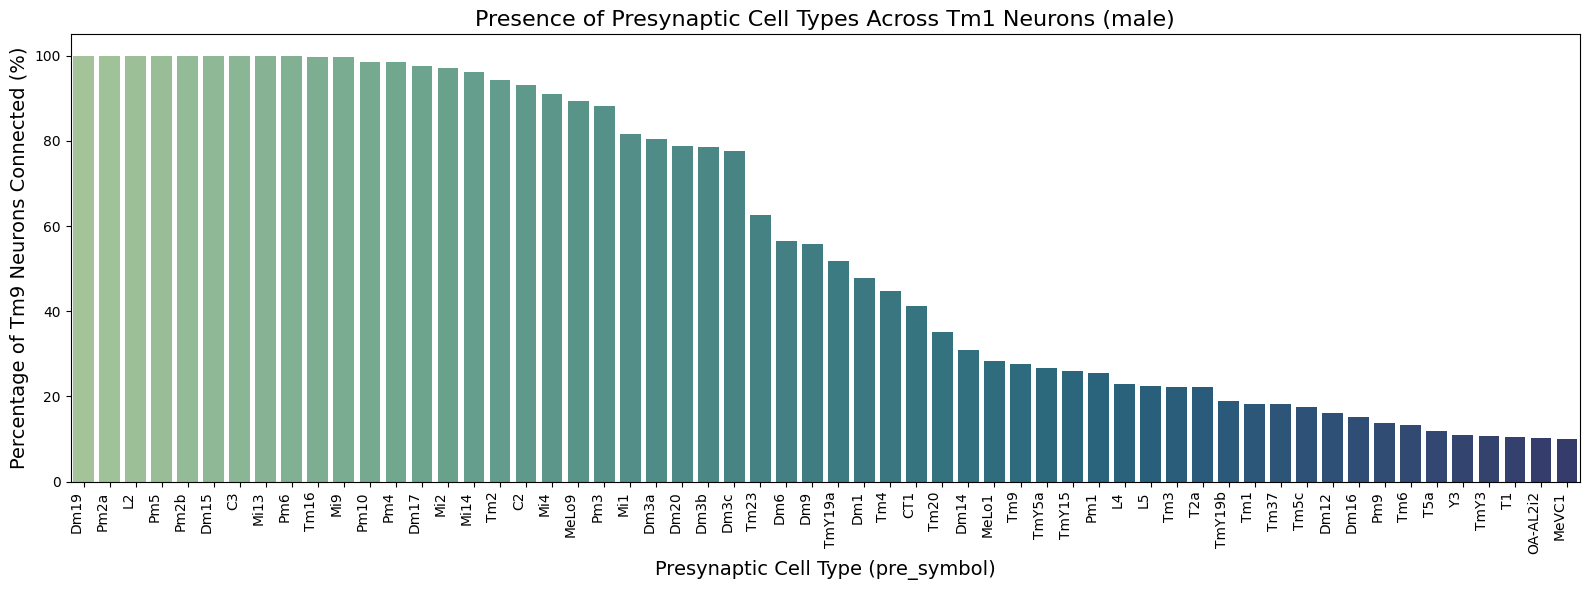

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
BASE_DIR = Path().resolve()
male_df = pd.read_csv(BASE_DIR / r'male_database.csv')
# Tm9
cell_of_interest = 'Tm1'
subset_df = male_df[male_df['post_symbol'] == cell_of_interest]
# Step 1: Get total unique post_root_ids
total_post_ids = subset_df['post_root_id'].nunique()

# Step 2: For each (post_root_id, pre_symbol), mark presence
presence_df = subset_df[['post_root_id', 'pre_symbol']].drop_duplicates()

# Step 3: For each pre_symbol, count how many unique post_root_ids it appears in
presence_counts = presence_df.groupby('pre_symbol')['post_root_id'].nunique().reset_index(name='post_count')

# Step 4: Convert to percentage
presence_counts['percentage'] = (presence_counts['post_count'] / total_post_ids) * 100

# Step 5: Sort and plot
presence_counts = presence_counts.sort_values(by='percentage', ascending=False)
lol = presence_counts[presence_counts['percentage']>10]
plt.figure(figsize=(16, 6))
sns.barplot(data=lol, x='pre_symbol', y='percentage', palette='crest')
plt.xticks(rotation=90, ha='right')
plt.ylabel('Percentage of Tm9 Neurons Connected (%)', fontsize=14)
plt.xlabel('Presynaptic Cell Type (pre_symbol)', fontsize=14)
plt.title(f'Presence of Presynaptic Cell Types Across {cell_of_interest} Neurons (male)', fontsize=16)
plt.tight_layout()
plt.show()


In [8]:
presence_df

,post_root_id,pre_symbol
0,24579,CT1
1,30145,CT1
2,38782,CT1
4,39810,CT1
5,40611,CT1
...,...,...
96876,46684,Tm20
96895,61016,Mi2
96897,68106,Mi2
96899,48214,C3


In [9]:
presence_counts


,pre_symbol,post_count,percentage
54,Dm19,890,100.00000
186,Pm2a,890,100.00000
67,L2,890,100.00000
190,Pm5,890,100.00000
187,Pm2b,890,100.00000
...,...,...,...
21,Cm24,1,0.11236
27,Cm30,1,0.11236
23,Cm27,1,0.11236
272,aMe4,1,0.11236


In [162]:
presence_df[presence_df['post_root_id']== 720575940616746845]

,post_root_id,pre_symbol
0,720575940616746845,T1
2290,720575940616746845,CB3833
2353,720575940616746845,Dm15
2395,720575940616746845,Dm3
5178,720575940616746845,Pm2
6096,720575940616746845,Dm6
8108,720575940616746845,C3
9312,720575940616746845,Mi2
9958,720575940616746845,Tm16
11549,720575940616746845,Tm5Y


In [163]:
presence_counts

,pre_symbol,post_count,percentage
100,Tm16,1467,96.449704
2,C3,1369,90.006575
76,Mi4,1361,89.480605
72,Mi13,1220,80.210388
38,CT1,1157,76.068376
...,...,...,...
62,LC14b,1,0.065746
83,R7,1,0.065746
63,LPi12,1,0.065746
97,Tlp4,1,0.065746
